In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
# filter out the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
cascades_path = '/usr/share/opencv/haarcascades/'
face_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_eye.xml')

In [3]:
import time

def current_time():
    return int(round(time.time() * 1000))

def get_right_left_eyes(roi_gray):
    # sort descending
    eyes = eye_cascade.detectMultiScale(roi_gray)
    eyes_sorted_by_size = sorted(eyes, key=lambda x: -x[2])
    largest_eyes = eyes_sorted_by_size[:2]
    # sort by x position
    largest_eyes.sort(key=lambda x: x[0])
    return largest_eyes

def extract_face_features(face, img, gray):
    [x,y,w,h] = face
    roi_gray = gray[y:y+h, x:x+w]
    face_image = np.copy(img[y:y+h, x:x+w])
    
    eyes = get_right_left_eyes(roi_gray)
    eye_images = []
    for (ex,ey,ew,eh) in eyes:
        eye_images.append(np.copy(img[y+ey:y+ey+eh,x+ex:x+ex+ew]))
                
    roi_color = img[y:y+h, x:x+w]
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
    
    return face_image, eye_images

def get_face_grid(face, frameW, frameH, gridSize):
    faceX,faceY,faceW,faceH = face

    return faceGridFromFaceRect(frameW, frameH, gridSize, gridSize, faceX, faceY, faceW, faceH, False)

def extract_image_features(full_img_path):
    img = cv2.imread(full_img_path)
    start_ms = current_time()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_detections = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    faces = []
    face_features = []
    for [x,y,w,h] in face_detections:
        face = [x, y, w, h]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        face_image, eye_images = extract_face_features(face, img, gray)
        face_grid = get_face_grid(face, img.shape[1], img.shape[0], 25)
        
        faces.append(face)
        face_features.append([face_image, eye_images, face_grid])
    
    duration_ms = current_time() - start_ms
    print("Face and eye extraction took: ", str(duration_ms / 1000) + "s")
    
    return img, faces, face_features

gridSize = 25

In [4]:
img, faces, face_features = extract_image_features('../appleFace00002/00000.jpg')

Face and eye extraction took:  0.256s


In [5]:
# This code is converted from https://github.com/CSAILVision/GazeCapture/blob/master/code/faceGridFromFaceRect.m

# Given face detection data, generate face grid data.
#
# Input Parameters:
# - frameW/H: The frame in which the detections exist
# - gridW/H: The size of the grid (typically same aspect ratio as the
#     frame, but much smaller)
# - labelFaceX/Y/W/H: The face detection (x and y are 0-based image
#     coordinates)
# - parameterized: Whether to actually output the grid or just the
#     [x y w h] of the 1s square within the gridW x gridH grid.

def faceGridFromFaceRect(frameW, frameH, gridW, gridH, labelFaceX, labelFaceY, labelFaceW, labelFaceH, parameterized):

    scaleX = gridW / frameW
    scaleY = gridH / frameH
    
    if parameterized:
      labelFaceGrid = np.zeros(4)
    else:
      labelFaceGrid = np.zeros(gridW * gridH)
    
    grid = np.zeros((gridH, gridW))

    # Use one-based image coordinates.
    xLo = round(labelFaceX * scaleX)
    yLo = round(labelFaceY * scaleY)
    w = round(labelFaceW * scaleX)
    h = round(labelFaceH * scaleY)

    if parameterized:
        labelFaceGrid = [xLo, yLo, w, h]
    else:
        xHi = xLo + w
        yHi = yLo + h

        # Clamp the values in the range.
        xLo = int(min(gridW, max(0, xLo)))
        xHi = int(min(gridW, max(0, xHi)))
        yLo = int(min(gridH, max(0, yLo)))
        yHi = int(min(gridH, max(0, yHi)))

        faceLocation = np.ones((yHi - yLo, xHi - xLo))
        grid[yLo:yHi, xLo:xHi] = faceLocation

        # Flatten the grid.
        grid = np.transpose(grid)
        labelFaceGrid = grid.flatten()
        
    return labelFaceGrid
      

In [6]:
def set_title_and_hide_axis(title):
    plt.title(title)
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)

def render_face_grid(face_grid):
    to_print = np.copy(face_grid)
    result_image = np.copy(to_print).reshape(25, 25).transpose()
    plt.figure()
    set_title_and_hide_axis('Face grid')
#     print(result_image.shape)
    plt.imshow(result_image)

def show_extraction_results(img, faces, face_features):
    plt.figure(figsize=(10,10))
    set_title_and_hide_axis('Original image and extracted features')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation="bicubic")

    for i, face in enumerate(faces):
        print('Face #' + str(i))
        #print('i', face, i)
        face_image, eye_images, face_grid = face_features[i]
        plt.figure()
        set_title_and_hide_axis('Extracted face image')
        plt.imshow(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")
        plt.figure()
        #print('face image after extraction')
        render_face_grid(face_grid)

        for eye_image in eye_images:
            plt.figure()

            #print('eye image after extraction')
            set_title_and_hide_axis('Extracted eye image')
            plt.imshow(cv2.cvtColor(eye_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")

In [7]:
img, faces, face_features = extract_image_features('../appleFace00002/00000.jpg')

Face and eye extraction took:  0.048s


In [109]:
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
#     with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
#         graph_def = tf.GraphDef()
#         graph_def.ParseFromString(f.read())
    with tf.Session(graph=tf.Graph()) as sess:
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], "./")
    return sess.graph

In [110]:
import os
# We use our "load_graph" function
graph = load_graph('saved_model.pb')

# We can verify that we can access the list of operations in the graph
for op in graph.get_operations():
    print(op.name)
    
# tensor = graph.get_tensor_by_name('facegrid:0')
# print(tensor.get_shape());

# We access the input and output nodes 
# x = graph.get_tensor_by_name('prefix/Placeholder/inputs_placeholder:0')
# y = graph.get_tensor_by_name('prefix/Accuracy/predictions:0')
        
# We launch a Session
#with tf.Session(graph=graph) as sess:
    # Note: we don't nee to initialize/restore anything
    # There is no Variables in this graph, only hardcoded constants 
    #y_out = sess.run(y, feed_dict={
     #   x: [[3, 5, 7, 4, 5, 1, 1, 1, 1, 1]] # < 45
    #})
    # I taught a neural net to recognise when a sum of numbers is bigger than 45
    # it should return False in this case
#print(y_out) # [[ False ]] Yay, it works!

INFO:tensorflow:Restoring parameters from b'./variables/variables'
save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/ShardedFilename/shard
save/num_shards
save/StringJoin/inputs_1
save/Const
save/RestoreV2
save/StringJoin
save/ShardedFilename
dense_6/bias
save/Assign_36
dense_6/bias/read
dense_6/bias/Initializer/Const
dense_6/bias/Assign
dense_6/kernel
save/Assign_37
dense_6/kernel/read
dense_6/kernel/Initializer/Const
dense_6/kernel/Assign
Flatten_7/flatten/Reshape/shape/1
Flatten_7/flatten/strided_slice/stack_2
Flatten_7/flatten/strided_slice/stack_1
Flatten_7/flatten/strided_slice/stack
dense_5/bias
save/Assign_34
dense_5/bias/read
dense_5/bias/Initializer/Const
dense_5/bias/Assign
dense_5/kernel
save/Assign_35
dense_5/kernel/read
dense_5/kernel/Initializer/Const
dense_5/kernel/Assign
Flatten_6/flatten/Reshape/shape/1
Flatten_6/flatten/strided_slice/stack_2
Flatten_6/flatten/strided_slice/stack_1
Flatten_6/flatten/

In [111]:
# def load_image(path):
# #     image_string = tf.read_file(path)
# #     image_decoded = tf.image.decode_image(image_string)
#     image_decoded = cv2.imread(path)[:,:,::-1]
#     return image_decoded

In [139]:
# for reading .mat files
import scipy.io
from scipy.ndimage import zoom
import skimage.io
from skimage.transform import resize


In [140]:
def load_image(filename, color=True):
    """
    Load an image converting from grayscale or alpha as needed.
    Parameters
    ----------
    filename : string
    color : boolean
        flag for color format. True (default) loads as RGB while False
        loads as intensity (if image is already grayscale).
    Returns
    -------
    image : an image with type np.float32 in range [0, 1]
        of size (H x W x 3) in RGB or
        of size (H x W x 1) in grayscale.
    """
    img = skimage.img_as_float(skimage.io.imread(filename, as_grey=not color)).astype(np.float32)
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
        if color:
            img = np.tile(img, (1, 1, 3))
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    return img

(224, 224, 3)


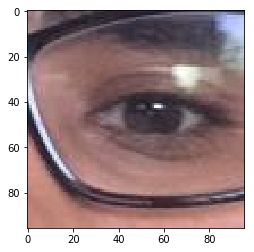

In [141]:

# load the mean images
mu_face = scipy.io.loadmat('../models/mean_images/mean_face_224.mat')
mu_right = scipy.io.loadmat('../models/mean_images/mean_right_224.mat')
mu_left = scipy.io.loadmat('../models/mean_images/mean_left_224.mat')
print(mu_face['image_mean'].shape)

# average over pixels to obtain the mean (RGB) pixel values
mu_face = mu_face['image_mean'].mean(0).mean(0)
mu_right = mu_right['image_mean'].mean(0).mean(0)  
mu_left = mu_left['image_mean'].mean(0).mean(0)  

# print(load_image('../appleLeftEye00003/00000.jpg').shape)
# plt.imshow(load_image('../appleLeftEye00003/00000.jpg'))

In [142]:
def resize_image(im, new_dims, interp_order=1):
    """
    Resize an image array with interpolation.
    Parameters
    ----------
    im : (H x W x K) ndarray
    new_dims : (height, width) tuple of new dimensions.
    interp_order : interpolation order, default is linear.
    Returns
    -------
    im : resized ndarray with shape (new_dims[0], new_dims[1], K)
    """
    if im.shape[-1] == 1 or im.shape[-1] == 3:
        im_min, im_max = im.min(), im.max()
        if im_max > im_min:
            # skimage is fast but only understands {1,3} channel images
            # in [0, 1].
            im_std = (im - im_min) / (im_max - im_min)
            resized_std = resize(im_std, new_dims, order=interp_order, mode='constant')
            resized_im = resized_std * (im_max - im_min) + im_min
        else:
            # the image is a constant -- avoid divide by 0
            ret = np.empty((new_dims[0], new_dims[1], im.shape[-1]),
                           dtype=np.float32)
            ret.fill(im_min)
            return ret
    else:
        # ndimage interpolates anything but more slowly.
        scale = tuple(np.array(new_dims, dtype=float) / np.array(im.shape[:2]))
        resized_im = zoom(im, scale + (1,), order=interp_order)
    return resized_im.astype(np.float32)

In [164]:
def face_transformer(path):
    face_image_decoded = load_image(path)
#     print(face_image_decoded)
    face_image_decoded = resize_image(face_image_decoded, (224, 224))
    face_image_decoded = np.subtract(face_image_decoded, mu_face);
#     print(np.transpose(face_image_decoded, [2,0,1]))
    face_image_decoded = np.reshape(face_image_decoded, [1,224,224,3]);
#     print(face_image_decoded.shape)
    return face_image_decoded

def right_transformer(path):
    right_image_decoded = load_image(path)
#     print(right_image_decoded)
    right_image_decoded = resize_image(right_image_decoded, (224, 224))
    right_image_decoded = np.subtract(right_image_decoded, mu_right);
#     print(np.transpose(right_image_decoded, [2,0,1]))
    right_image_decoded = np.reshape(right_image_decoded, [1,224,224,3]);
#     print(right_image_decoded.shape)
    return right_image_decoded

def left_transformer(path):
    left_image_decoded = load_image(path)
    left_image_decoded = resize_image(left_image_decoded, (224, 224))
    left_image_decoded = np.subtract(left_image_decoded, mu_left);
#     print(np.transpose(left_image_decoded, [2,0,1]))
    left_image_decoded = np.reshape(left_image_decoded, [1,224,224,3]);
#     print(left_image_decoded.shape)
    return left_image_decoded

def facegrid_transformer(path):
    facegrid_decoded = load_image(path)
    np.transpose(facegrid_decoded);
    np.reshape(facegrid_decoded, [625, 1, 1]);
#     print(facegrid_decoded.shape)
    return facegrid_decoded



In [188]:
image_face = graph.get_tensor_by_name('image_face:0')
image_right= graph.get_tensor_by_name('image_right:0')
image_left = graph.get_tensor_by_name('image_left:0')
facegrid = graph.get_tensor_by_name('facegrid:0')

output = graph.get_tensor_by_name('dense_6/BiasAdd:0')


In [205]:
face = face_transformer('../appleFace00003/00070.jpg')
right = right_transformer('../appleRightEye00003/00070.jpg')
left = left_transformer('../appleLeftEye00003/00070.jpg')
grid = scipy.io.loadmat('../facegrid00003.mat')['labelFaceGrid'].T
print(print(np.reshape(grid, (25, 25))))
grid = np.reshape(grid, (1,1,1,625))



[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 

In [206]:
with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    y_out = sess.run(output, feed_dict={
            image_face: face, image_right: right, image_left: left, facegrid:grid 
        })

print(y_out) 

[[-0.5303627 -6.591156 ]]
